# Assignment 7

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research.

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples.

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning.

# DATA_PATH = "/Users/jorgesandoval/Desktop/DATASCI207/EuroSAT"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile

# Define the path to the zip file in your Google Drive
# Here we derive the path from your shared link
zip_path = '/content/drive/My Drive/EuroSAT.zip'

# Define the extraction path
extract_path = '/content/EuroSAT'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
print("Files extracted to:", extract_path)

DATA_PATH = '/content/EuroSAT'

Files extracted to: /content/EuroSAT


^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [4]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels.

    Parameters:
    path_to_data (str): This is the path to the data.

    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    '''
    images = []
    labels = []

    # Traverse the directory structure
    for root, dirs, files in os.walk(path_to_data):
        for file_name in files:
            # Skip macOS metadata files
            if file_name.startswith('._'):
                continue

            # Create the full path to the image file
            full_path = os.path.join(root, file_name)

            # Check if the file is an image
            if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                continue

            try:
                # Load and resize the image
                image = load_img(full_path, target_size=(64, 64))

                # Convert the image to a numpy array
                image_array = img_to_array(image)

                # Append the image array to the images list
                images.append(image_array)

                # Extract the label from the directory name
                label = os.path.basename(root)
                labels.append(label)
            except Exception as e:
                # Handle any errors encountered during image processing
                continue

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [5]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)

Shape of images: (27000, 64, 64, 3)
Shape of labels: (27000,)


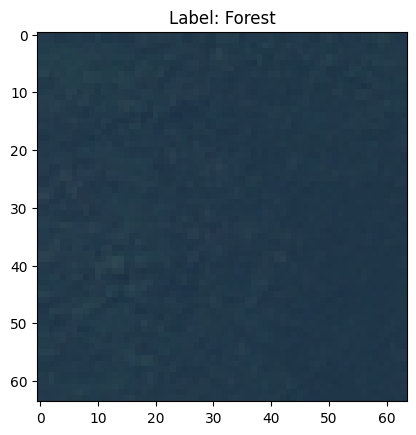

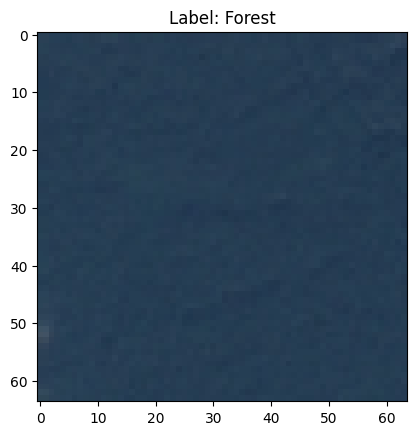

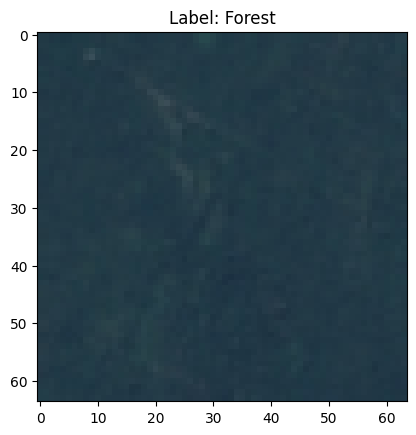

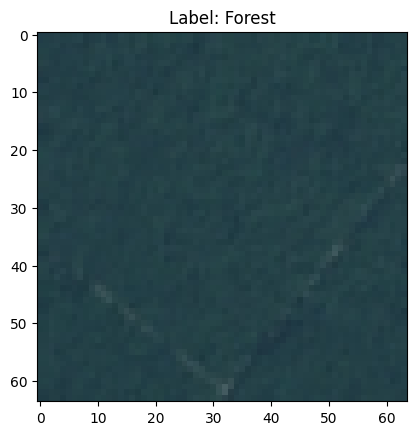

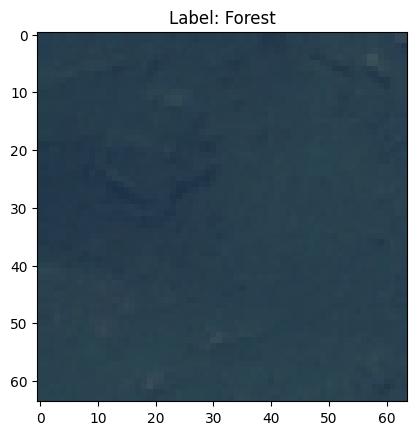

In [6]:
# Checking to see if images imported correctly
for i in range(5):
    plt.imshow(images[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.show()


---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

<ipython-input-7-39e558366919>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = label_counts.index,y = label_counts.values, palette = 'viridis')


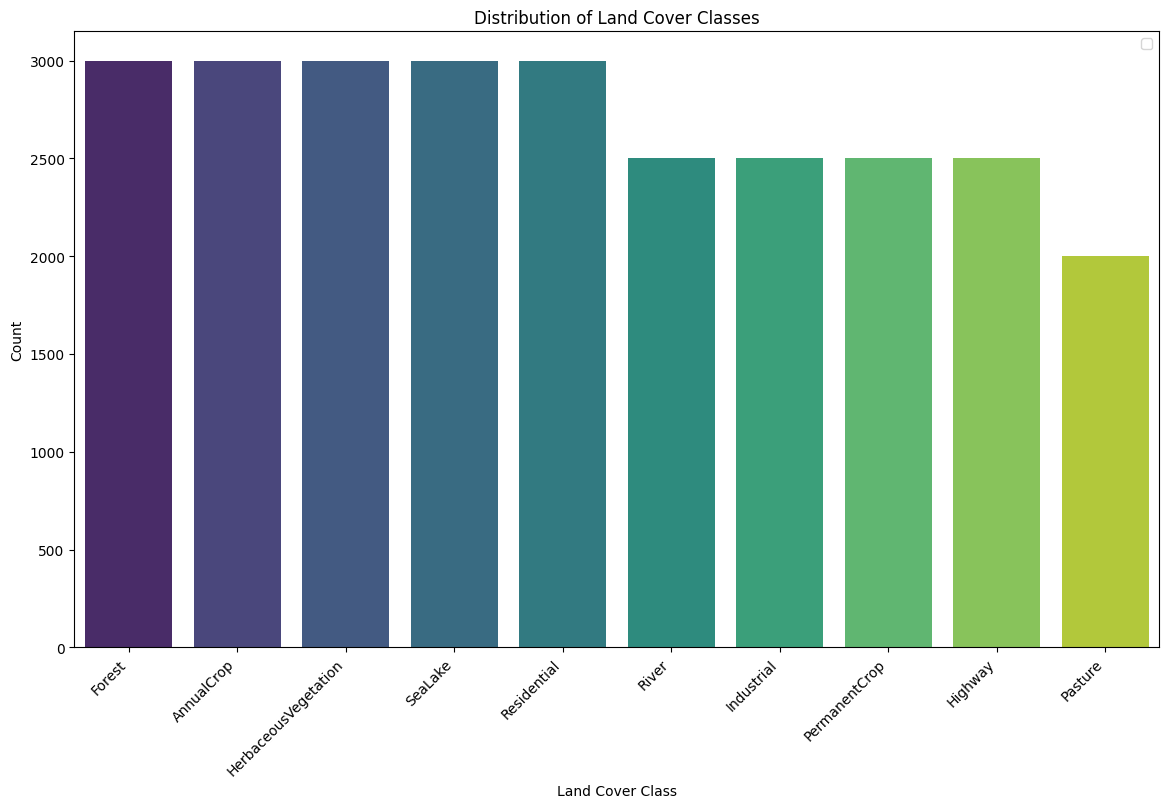

In [7]:
# Plotting distribution

# Convert labels to a Pandas Series for better handling
label_pSeries = pd.Series(labels)

# Count the number of occurrences of each label
label_counts = label_pSeries.value_counts()

# Set the figure size for the plot
plt.figure(figsize= (14,8))

# Create a bar plot of the label counts
sns.barplot(x = label_counts.index,y = label_counts.values, palette = 'viridis')

# Labels
plt.xlabel('Land Cover Class')
plt.ylabel('Count')
plt.title('Distribution of Land Cover Classes')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.legend()
plt.show()

Comment on class balance: The clases are mostly balanced. Half of the labels have 3000 images while the rest have 2500 except for pasture which has the lowest at 2000 images

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

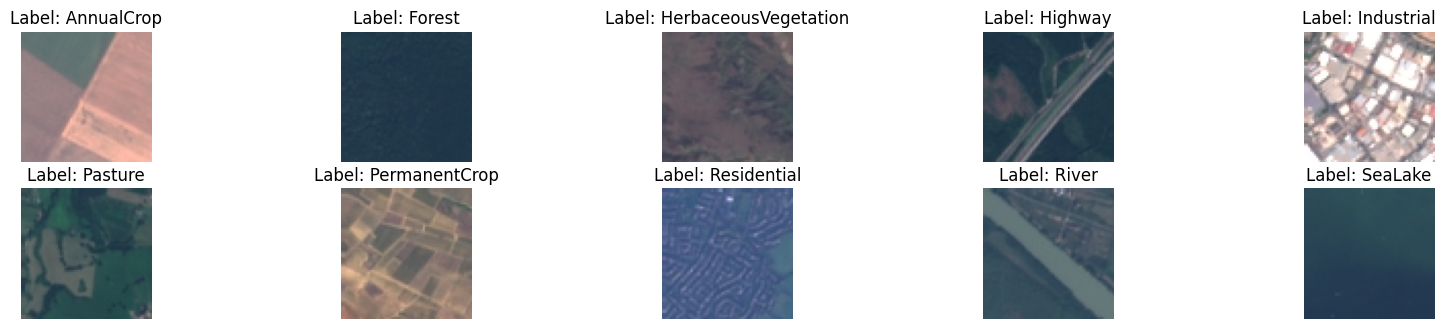

In [8]:
# Create a DF of all the images
df = pd.DataFrame({'image': list(images), 'label': labels})

# Create a sub DF with the first image of each label
unique_classes = df.groupby('label').first().reset_index()

# Set the figure size for better visualization
plt.figure(figsize=(20, 20))

# Loop through each unique class and plot the first image
for i in range(len(unique_classes)):
    plt.subplot(len(unique_classes), 5, i + 1)
    plt.imshow(unique_classes['image'].iloc[i].astype('uint8'))  # Display the image
    plt.title(f"Label: {unique_classes['label'].iloc[i]}")  # Set the title to the class label
    plt.axis('off')  # Hide the axis

# Show the plot
plt.show()

I think the model will confuse:
- Forest with sea lake
- Pasture with sea lake
- Highway with industrial

---
### Step 3: Data preprocessing

Encode labels

In [9]:
# Maps each unique label to a unique integer.
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels

# The transform method applies encoding to the original labels array
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)

encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [10]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.

    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    # Shuffle data
    indices = np.arange(len(labels))
    np.random.shuffle(indices)

    shuffled_images = images[indices]
    shuffled_labels = labels[indices]

    # Determine where to split the data based on the provided split ratios.
    total_images = len(images)
    train_end = int(split[0] * total_images)
    val_end = train_end + int(split[1] * total_images)

    # Slice the shuffled arrays into training, validation, and test sets.
    X_train, y_train = shuffled_images[:train_end], shuffled_labels[:train_end]
    X_val, y_val = shuffled_images[train_end:val_end], shuffled_labels[train_end:val_end]
    X_test, y_test = shuffled_images[val_end:], shuffled_labels[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation.

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only:
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [12]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;

    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    data_partition (str): "train"

    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)

    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3

    # image augmentation on training data
    if data_partition=="train":
        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X, CONTRAST_FACTOR)

        # random flip
        X_augm = tf.image.flip_left_right(X)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor


    # rescale image by dividing each pixel by 255.0
    X = X / 225.0

    return X, y

The importance of adding augmented images to the training data is to:
- Simulate Real-World Conditions:
  - The smae landscape will not always appear the same. Changes in time of day, weather and season affect the apperance of landscapes. Augmenting the training images simuates this change.
- Prevent Overfiiting
  - Adding these augmented images prevents our moddel to overfit the training data. It helps expose our model to a more robust set of training data.
- Increases Dataset
  - By adding more datapoints to our training data our model has more to learn from, which may result in better accuracy.

We do not touch the validation/test sets because we dont want to mess with the results. The purpose of the validation/test sets provide an unbiased evaluation of the model's performance and it would be biased if we messed with them. Another reason why we dont alter these data sets is because we want to reflect real-world data as closely as possible, without any artificial alterations.

In [13]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible klearn Decision Forests)

In [14]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

In [15]:
from sklearn.ensemble import RandomForestClassifier

#constructs multiple decision trees during training and outputs the class that is the mode of the classes (classification) of the individual trees.
rfc = RandomForestClassifier(n_estimators = 2, criterion = 'gini', max_depth = 8, min_samples_split = 2, min_samples_leaf = 1, min_weight_fraction_leaf = 0.0, max_features = 'auto', max_leaf_nodes = None, bootstrap = True, n_jobs = 1, random_state = 7, verbose = 0, warm_start = False, class_weight = None)

#Train the model
rfc.fit(X_train_re, y_train)

#Evaluate the accuracy of the model
y_train_pred = rfc.predict(X_train_re)
y_val_pred = rfc.predict(X_val_re)

baseline_val_pred = accuracy_score(y_val, y_val_pred)
# Output accuracy
print('Training Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Validation Accuracy: ', baseline_val_pred)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Training Accuracy:  0.510895061728395
Validation Accuracy:  0.46814814814814815


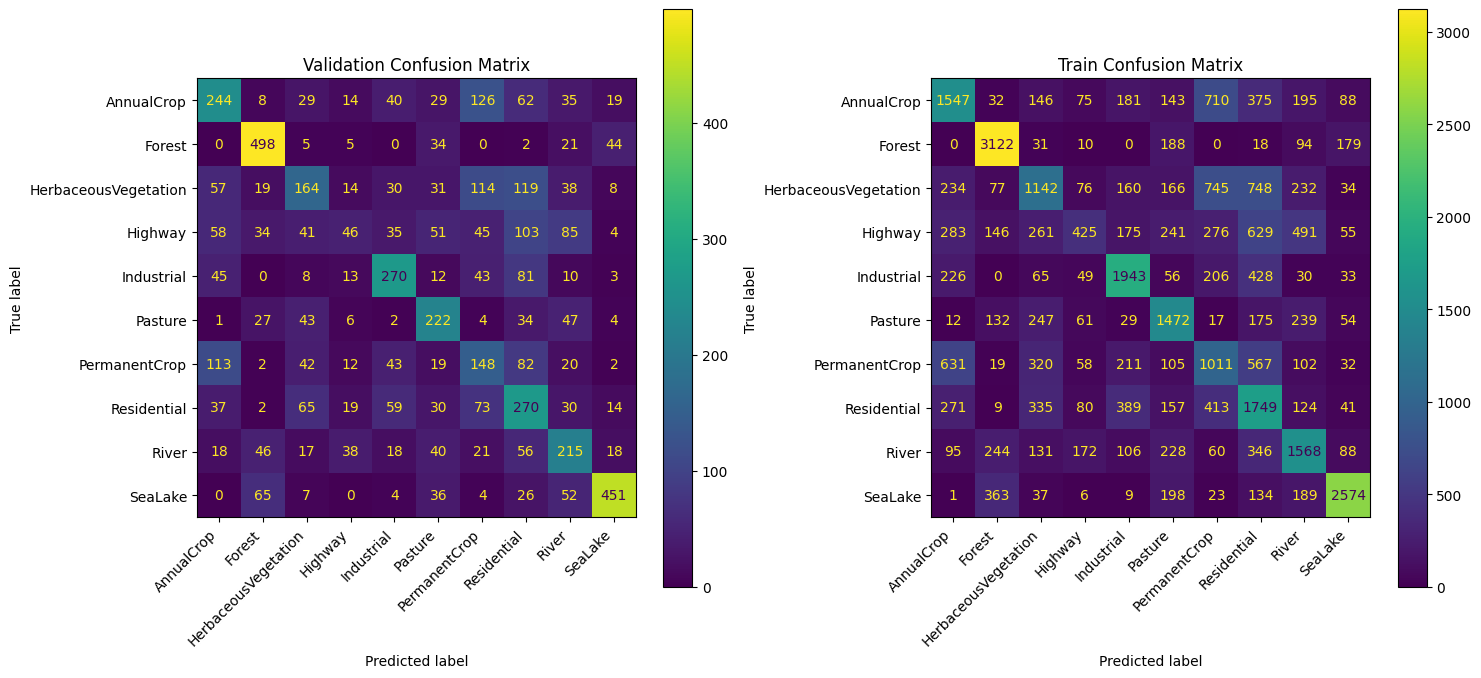

In [16]:
# A confusion matrix is a table used to evaluate the performance of a classification model.
# It summarizes the prediction results by comparing the actual true values with the predicted values.

cm1 = confusion_matrix(y_val, y_val_pred)
cm2 = confusion_matrix(y_train, y_train_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot the training confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = encoded_labels_classes)
disp2.plot(ax = axes[1], xticks_rotation=45)
axes[1].set_title('Train Confusion Matrix')

# Plot the validation confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = encoded_labels_classes)
disp1.plot(ax = axes[0],xticks_rotation=45)
axes[0].set_title('Validation Confusion Matrix')

for ax in axes:
  plt.sca(ax)  # Set the current axes to apply plt.xticks to the correct subplot
  plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Comment on model accuracy on training vs. validation data:

Training CM:
- The model performs exceptionally well on the training set
- Might be signs of overfitting

Both CM's:
- Both matrices show similar misclassification patterns
- Confusion between "Highway" and "Residential", and between "PermanentCrop" and "AnnualCrop"

*Key take aways on the models preformance:*

Many "Highway" instances were misclassified as "Residential"
- (99 times).

Some "Highway" instances were misclassified as "Industrial"
- (24 times).

- Since "Forest" and "SeaLake", have a much higher number of instances than others this may lead to biased towards the majority classes

- Overall both CM's seem to provide similar results

Does the model generalize well?:

Our current model struggels to generalize, specifically with the high performance on the training data and lower preformance on the validation data. We can also obser that both diagonals contain high numbers.  

Comment on the classes that the model confuses the most: Highway" and "Residential", and between "PermanentCrop" and "AnnualCrop"

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). The model should also generalize well (the performance difference between the training and validation sets should be at most 10%). Also, be sure to follow these guidelines:
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Does your model generalize well?
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

Val Baseline Acc: 0.4575925925925926

In [17]:
# RandomForestClassifier

# Build the model
rf_clf2 = RandomForestClassifier(n_estimators = 100 , n_jobs = -1, random_state = 7, max_depth = 14)

# Fit the model
rf_clf2.fit(X_train_re, y_train)

# Evaluate the model
X_val_pred = rf_clf2.predict(X_val_re)

print("Accuracy for Validation is:", accuracy_score(y_val, X_val_pred))

Accuracy for Validation is: 0.6668518518518518


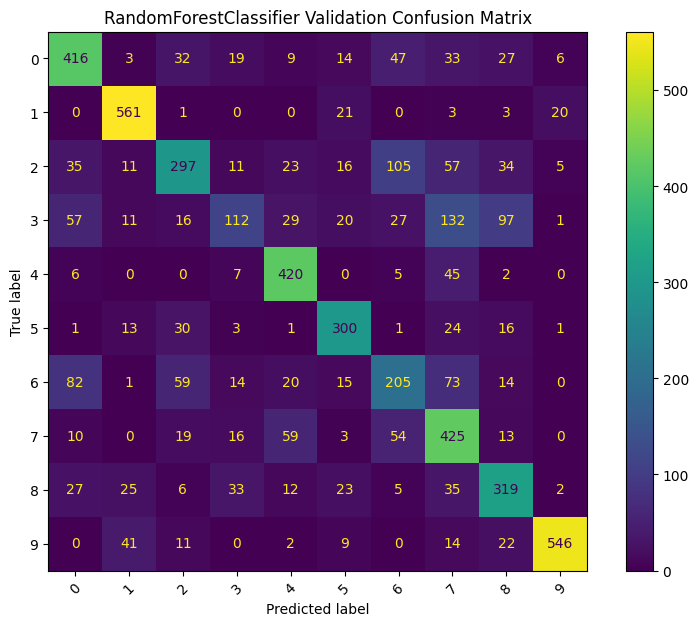

In [18]:
# Confusion Matrix for RandomForestClassifier
cm_rf = confusion_matrix(y_val, X_val_pred)
fig, ax = plt.subplots(figsize=(10, 7))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(ax=ax, xticks_rotation=45)
ax.set_title('RandomForestClassifier Validation Confusion Matrix')
plt.show()

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

# ExtraTreeClassifier

# Build Model
etc = ExtraTreesClassifier(n_estimators = 100, n_jobs = -1, min_samples_split = 5, min_samples_leaf = 2, random_state = 7, max_depth = 14, max_features = 'sqrt', bootstrap = True )

# Train Model Fit
etc.fit(X_train_re, y_train)

# Evaluate Model Predict
X_val_pred = etc.predict(X_val_re)

print("Accuracy: ", accuracy_score(y_val ,X_val_pred))

Accuracy:  0.6512962962962963


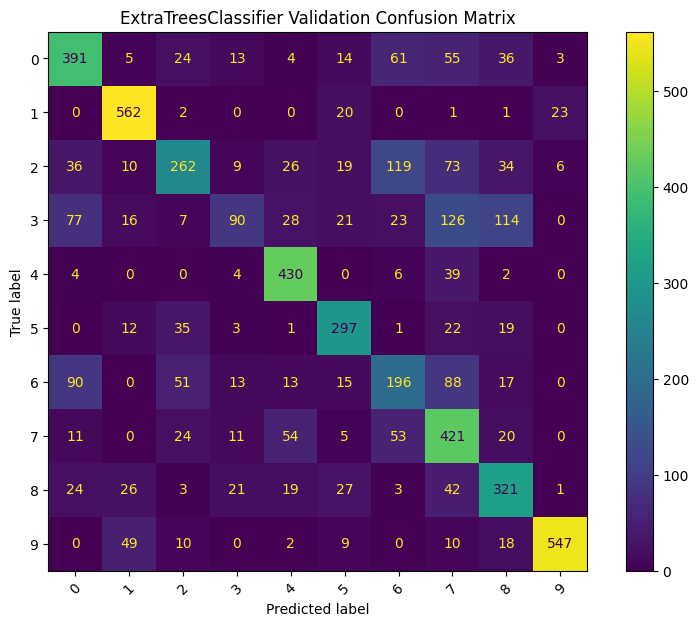

In [21]:
# Confusion Matrix for ExtraTreesClassifier
cm_etc = confusion_matrix(y_val, X_val_pred)
fig, ax = plt.subplots(figsize=(10, 7))
disp_etc = ConfusionMatrixDisplay(confusion_matrix=cm_etc)
disp_etc.plot(ax=ax, xticks_rotation=45)
ax.set_title('ExtraTreesClassifier Validation Confusion Matrix')
plt.show()

In [22]:
from sklearn.ensemble import ExtraTreesClassifier

# ExtraTreeClassifier

# Build Model
etcL = ExtraTreesClassifier(n_estimators = 100, n_jobs = -1, min_samples_split = 5, min_samples_leaf = 2, random_state = 7, max_depth = 14, max_features = 'log2', bootstrap = True )

# Train Model Fit
etcL.fit(X_train_re, y_train)

# Evaluate Model Predict
X_val_pred = etcL.predict(X_val_re)

print("Accuracy: ", accuracy_score(y_val ,X_val_pred))

Accuracy:  0.6322222222222222


In [23]:
# RandomForestClassifier

# Build the model
rf_clf3 = RandomForestClassifier(n_estimators = 200 , n_jobs = -1, random_state = 7, max_depth = 14)

# Fit the model
rf_clf3.fit(X_train_re, y_train)

# Evaluate the model
X_val_pred = rf_clf3.predict(X_val_re)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.46814814814814815


How your implementation is different compared to the baseline classifier:

I tried using Extra Trees Classifier & Gradient Boosting Classifier however the Random Forest Classifier returned the best results, achieving an accuracy of 0.6557407407407407. I incremented the number of estimators to 200, a max depth of 14 and utiliezed all availabe cores

Comment on training vs. validation performance relative to baseline model: The model did better on the training data than the validation data.

Does the model generalize well? It generalizes slightly better but in the grand scheme of things no it does not generalize better

Comment on the classes the model confuses the most relative to the baseline:
- The RandomForestClassifier shows a general improvement in accuracy
- AnnualCrop with PermanentCrop and HerbaceousVegetation with Residential still exhibit some level of confusion
- Model reduces misclassifications for Forest, HerbaceousVegetation, and Highway

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the validation set?

In [25]:
# RandomForestClassifier

# Build the model
test_Model = RandomForestClassifier(n_estimators = 200 , n_jobs = -1, random_state = 7, max_depth = 14)

# Fit the model on the training data
test_Model.fit(X_train_re, y_train)

# Evaluate the model on test data
y_test_pred = test_Model.predict(X_test_re)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.6622222222222223


In [27]:
# Evaluate the model on validation data
y_val_pred = test_Model.predict(X_val_re)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.6718518518518518


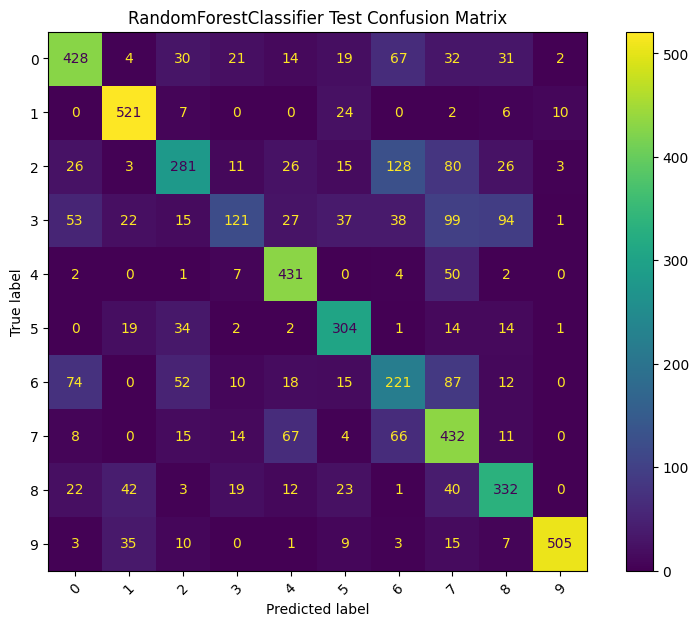

In [26]:
# Plot the confusion matrix for the test data
cm_test = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(10, 7))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=ax, xticks_rotation=45)
ax.set_title('RandomForestClassifier Test Confusion Matrix')
plt.show()

Comment on test set accuracy vs. validation set accuracy:
- Test Accuracy: 0.6622222222222223
- Validation Accuracy: 0.6718518518518518

Slight overfitting is observed but not big enough to cause a significant issue

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

Seeing the results of all the models we built and comparing them, I was unable to get an accarcy score over 70%

That being said I may just suck, or Decision Forests just arnt efficient enough to distinguish between classes that are very similar.

Another note, trying all the models did cost a considerable amount of time leading to a late turn in.

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

I would go with a Convolutional Neural Network model to try to improve preformance. They are very effective at capturing local patterns making them great for image classification.

---
#### <span style="color:chocolate"> Bonus question (20 points) </span>

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [28]:
# Importing necessary libraries from TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

In [34]:
# Define the CNN model architecture
model = Sequential([
    # Convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    # Max pooling layer with 2x2 pool size
    MaxPooling2D(pool_size=(2, 2)),

    # Second convolutional layer with 64 filters and 3x3 kernel
    Conv2D(64, (3, 3), activation='relu'),
    # Second max pooling layer with 2x2 pool size
    MaxPooling2D(pool_size=(2, 2)),

    # Third convolutional layer with 128 filters and 3x3 kernel
    Conv2D(128, (3, 3), activation='relu'),
    # Third max pooling layer with 2x2 pool size
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the pooled feature maps into a 1D feature vector
    Flatten(),

    # Fully connected layer with 128 units and ReLU activation
    Dense(128, activation='relu'),
    # Dropout layer to reduce overfitting
    Dropout(0.5),

    # Output layer with 10 units (one for each class) and softmax activation for classification
    Dense(10, activation='softmax')
])

In [35]:
# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 128)        

We started with a Sequential model, which allows us to add layers one after another in a sequential order.

Conv2D Layers: These layers apply convolution operations to the input image, using filters to capture local patterns like edges, textures, etc.  

MaxPooling2D Layers: These layers perform compression whihc helps to make the network more computationally efficient and reduces the risk of overfitting.

After the convolutional and pooling layers, we use a Flatten layer to convert the 3D feature maps into a 1D feature vector.

Dense Layers: These layers are neurons connected to every neuron in the previous layer.




In [36]:
# Convert labels to categorical (one-hot encoding)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val_cat)
)


Epoch 1/25
1013/1013 [==============================] - 241s 236ms/step - loss: 1.2790 - accuracy: 0.5333 - val_loss: 0.7679 - val_accuracy: 0.7476
Epoch 2/25
1013/1013 [==============================] - 232s 229ms/step - loss: 0.8775 - accuracy: 0.6920 - val_loss: 0.6551 - val_accuracy: 0.7691
Epoch 3/25
1013/1013 [==============================] - 243s 239ms/step - loss: 0.7352 - accuracy: 0.7428 - val_loss: 0.5523 - val_accuracy: 0.8087
Epoch 4/25
1013/1013 [==============================] - 239s 236ms/step - loss: 0.6649 - accuracy: 0.7673 - val_loss: 0.5040 - val_accuracy: 0.8252
Epoch 5/25
1013/1013 [==============================] - 234s 231ms/step - loss: 0.5934 - accuracy: 0.7938 - val_loss: 0.5048 - val_accuracy: 0.8256
Epoch 6/25
1013/1013 [==============================] - 246s 243ms/step - loss: 0.5383 - accuracy: 0.8130 - val_loss: 0.4262 - val_accuracy: 0.8550
Epoch 7/25
1013/1013 [==============================] - 229s 226ms/step - loss: 0.4913 - accuracy: 0.8305 - val_

In [37]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print("Test Accuracy:", test_accuracy)

# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val_cat)
print("Validation Accuracy:", val_accuracy)

# Make predictions on the validation data
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Confusion Matrix for validation data
cm = confusion_matrix(y_val, y_val_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoded_labels_classes)


169/169 [==============================] - 12s 68ms/step - loss: 0.3455 - accuracy: 0.9087
Test Accuracy: 0.9087036848068237
169/169 [==============================] - 14s 81ms/step - loss: 0.3464 - accuracy: 0.9109
Validation Accuracy: 0.9109259247779846
169/169 [==============================] - 12s 67ms/step


<Figure size 1000x700 with 0 Axes>

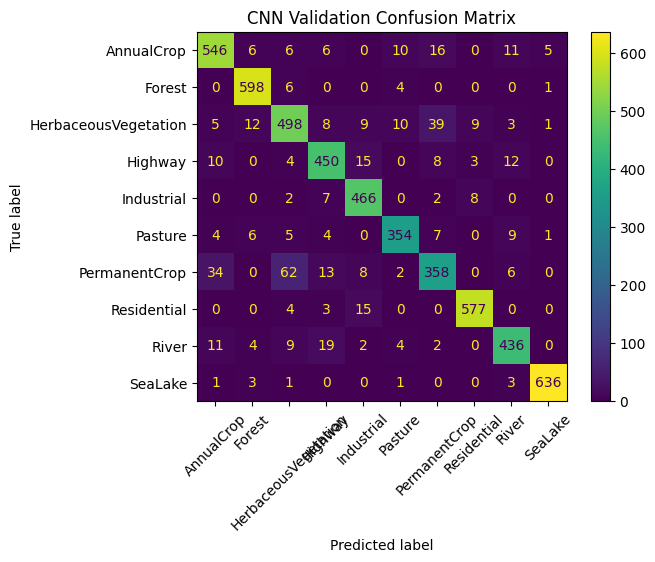

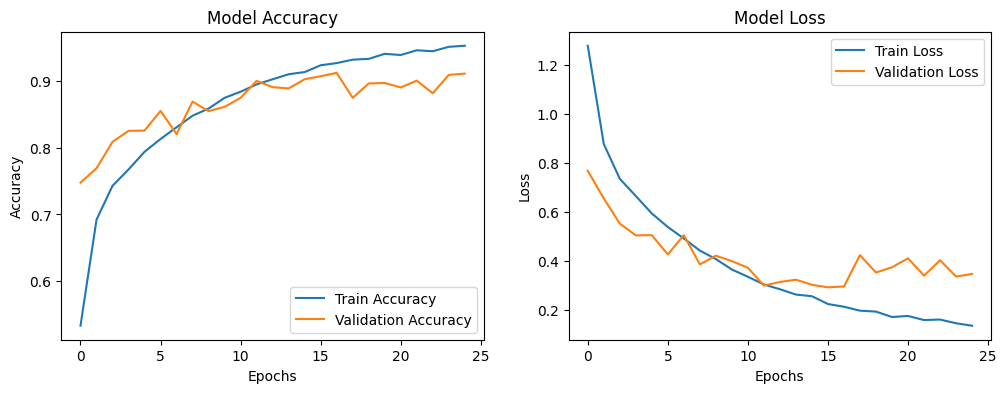

In [38]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(xticks_rotation=45)
plt.title('CNN Validation Confusion Matrix')
plt.show()

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

###Summary of what we did!###
First, we imported essential libraries to handle image processing, neural network construction, and data manipulation. TensorFlow and Keras were used for building and training the neural network, while other libraries like NumPy, pandas, and sklearn were used for data manipulation and evaluation.

We started by loading images from the specified directory, resizing them to 64x64 pixels, and extracting their labels from the directory structure. This preprocessing step ensured that the image data was uniform and ready for training. The class labels were then encoded into integers using `LabelEncoder` from sklearn, as machine learning models require numerical input. The dataset was split into training, validation, and test sets to evaluate the model's performance on unseen data and ensure it generalizes well. Training data is used to train the model, validation data to tune the model, and test data to evaluate the final model performance.

Next, we applied data augmentation techniques to the training data and normalized the pixel values of all images. Data augmentation increased the diversity of the training data, reducing overfitting, while normalization scaled the pixel values to a range of 0-1, aiding in faster and more stable training. Augmentation techniques such as flipping and adjusting brightness/contrast created variations of the training images, and normalization ensured the neural network processed the images efficiently.

We then built a CNN using the Sequential API from Keras. Three convolutional layers, each followed by a max pooling layer, were added to the model. Convolutional layers detected local patterns such as edges and textures, while pooling layers reduced the spatial dimensions of the feature maps, making the computation more efficient and reducing overfitting. Stacking multiple convolutional layers allowed the model to learn increasingly complex features at each layer, and pooling layers compressed the information while retaining essential features. After the convolutional layers, a flatten layer converted the 3D feature maps into a 1D feature vector, preparing the data for the fully connected layers. A dense layer with 128 neurons and a dropout layer were added, followed by an output layer with 10 neurons (one for each class) and a softmax activation function. Dense layers performed the final classification based on the features extracted by the convolutional layers, and the dropout layer helped reduce overfitting by randomly setting a fraction of input units to 0 during training. The softmax activation in the output layer converted the outputs into probabilities for each class.

The model was compiled using the Adam optimizer and categorical cross-entropy loss. This step configured the model for training, with the Adam optimizer being efficient for large datasets and categorical cross-entropy suitable for multi-class classification problems. The model was trained using the training data, with validation data used to monitor its performance. The training process adjusted the model weights to reduce the loss, improving its accuracy on the training and validation sets. The model was then evaluated on the test data to assess how well it generalized to new, unseen data, providing an unbiased estimate of the model's accuracy.

Predictions were made on the validation data, and a confusion matrix was plotted to visualize the classification performance. This analysis helped to identify which classes were being misclassified, providing insights into the model's strengths and weaknesses. Finally, we plotted the training and validation accuracy and loss over the epochs to visualize the learning process and check for overfitting or underfitting. Monitoring accuracy and loss helped in understanding the model's performance trend over time and adjusting training parameters if necessary. This comprehensive approach ensured that the CNN model was properly built, trained, and evaluated for the image classification task, leveraging various techniques to improve performance and generalization.